# Predicting Student Admissions

In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

_Note: Thanks Adam Uccello, for helping us debug!_

In [1]:
import time
start_time = time.time()

## 1. Load and visualize the data

To load the data, we will use a very useful data package called Pandas. You can read on Pandas documentation here:

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense



/home/yannis/anaconda3/envs/working/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


Let's plot the data and see how it looks.

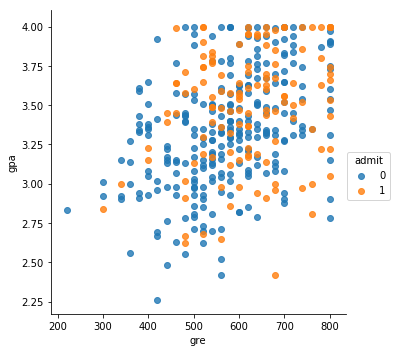

In [5]:
sns.lmplot(x='gre', y='gpa', data=data, hue='admit', fit_reg=False)

The data, based on only GRE and GPA scores, doesn't seem very separable. Maybe if we make a plot for each of the ranks, the boundaries will be more clear.

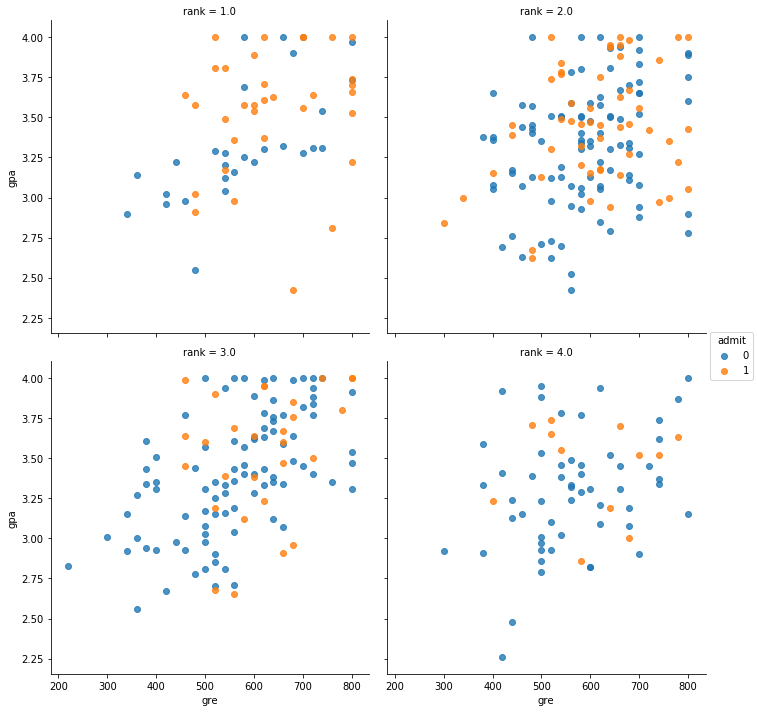

In [6]:
g = sns.lmplot(
    data=data,
    x='gre',
    y='gpa',
    hue='admit',
    col='rank',
    col_wrap=2,
    fit_reg=False)

These plots look a bit more linearly separable, although not completely. But it seems that using a multi-layer perceptron with the rank, gre, and gpa as inputs, may give us a decent solution.

# 2. Process the data
We'll do the following steps to clean up the data for training:
- One-hot encode the rank
- Normalize the gre and the gpa scores, so they'll be in the interval (0,1)
- Split the data into the input X, and the labels y.

In [7]:
# remove NaNs
data = data.fillna(0)

# One-hot encoding the rank
processed_data = pd.get_dummies(data, columns=['rank'])

# Normalizing the gre and the gpa scores to be in the interval (0,1)
processed_data["gre"] = processed_data["gre"]/800
processed_data["gpa"] = processed_data["gpa"]/4

# Splitting the data input into X, and the labels y 
X = np.array(processed_data)[:,1:]
X = X.astype('float32')
y = keras.utils.to_categorical(data["admit"],2)

In [8]:
print("Shape of X:", X.shape)
print("\nShape of y:", y.shape)
print("\nFirst 10 rows of X")
print(X[:10])
print("\nFirst 10 rows of y")
print(y[:10])

Shape of X: (400, 7)

Shape of y: (400, 2)

First 10 rows of X
[[0.475  0.9025 0.     0.     0.     1.     0.    ]
 [0.825  0.9175 0.     0.     0.     1.     0.    ]
 [1.     1.     0.     1.     0.     0.     0.    ]
 [0.8    0.7975 0.     0.     0.     0.     1.    ]
 [0.65   0.7325 0.     0.     0.     0.     1.    ]
 [0.95   0.75   0.     0.     1.     0.     0.    ]
 [0.7    0.745  0.     1.     0.     0.     0.    ]
 [0.5    0.77   0.     0.     1.     0.     0.    ]
 [0.675  0.8475 0.     0.     0.     1.     0.    ]
 [0.875  0.98   0.     0.     1.     0.     0.    ]]

First 10 rows of y
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


# 3. Split the data into training and testing sets

In [9]:
# break training set into training and validation sets
(X_train, X_test) = X[50:], X[:50]
(y_train, y_test) = y[50:], y[:50]

# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (350, 7)
350 train samples
50 test samples


# 4. Define the model architecture

In [10]:
def build_model(activation='sigmoid',
                loss_function='categorical_crossentropy',
                optimizer='adam'):
    # Building the model
    # Note that filling out the empty rank as "0", gave us an extra column, for "Rank 0" students.
    # Thus, our input dimension is 7 instead of 6.
    model = Sequential()
    model.add(Dense(128, activation=activation, input_shape=(7, )))
    model.add(Dense(64, activation=activation))
    model.add(Dense(2, activation=activation))

    # Compiling the model
    model.compile(
        loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
    #model.summary()

    return model

# 5. Train the model

In [11]:
def train_model(model, X_train, y_train, epochs=1000):
    # Training the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=100, verbose=0)
    
    return model

# 6. Score the model

In [12]:
def score_model(model):
    # Evaluating the model on the training and testing set
    score = model.evaluate(X_train, y_train)
    print("\n Training Accuracy:", score[1])
    score = model.evaluate(X_test, y_test)
    print("\n Testing Accuracy:", score[1])

# 7. Playing around

In [13]:
for activation in ['relu', 'sigmoid']:
    for loss in ['categorical_crossentropy', 'mean_squared_error']:
        for optimizer in ['rmsprop', 'adam']:
            model = build_model(activation, loss, optimizer)
            model = train_model(model, X_train, y_train)
            print(
                'Activation Function = ' + activation + ', ' +
                'Loss Function = ' + loss + ', ' + 'Optimizer = ' + optimizer)
            score_model(model)

Activation Function = relu, Loss Function = categorical_crossentropy, Optimizer = rmsprop
350/350 [==============================] - 0s 57us/step

 Training Accuracy: 0.300000000340598
50/50 [==============================] - 0s 50us/step

 Testing Accuracy: 0.4400000023841858
Activation Function = relu, Loss Function = categorical_crossentropy, Optimizer = adam
350/350 [==============================] - 0s 102us/step

 Training Accuracy: 0.6999999996594021
50/50 [==============================] - 0s 71us/step

 Testing Accuracy: 0.5599999976158142
Activation Function = relu, Loss Function = mean_squared_error, Optimizer = rmsprop
350/350 [==============================] - 0s 103us/step

 Training Accuracy: 0.7485714306150164
50/50 [==============================] - 0s 62us/step

 Testing Accuracy: 0.6000000095367432
Activation Function = relu, Loss Function = mean_squared_error, Optimizer = adam
350/350 [==============================] - 0s 111us/step

 Training Accuracy: 0.7542857163

The model has the best performance with the following configuration:
* Activation Function = sigmoid,
* Loss Function = mean_squared_error,
* Optimizer = rmsprop

In [14]:
model = build_model('sigmoid', 'mean_squared_error', 'rmsprop')
model = train_model(model, X_train, y_train)
score_model(model)

350/350 [==============================] - 0s 245us/step

 Training Accuracy: 0.7142857166699
50/50 [==============================] - 0s 56us/step

 Testing Accuracy: 0.6799999976158142


In [15]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [16]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [17]:
end_time = time.time()
print(end_time - start_time)

104.5416784286499
